Imports

In [51]:
import os

import matplotlib.pyplot as plt
import numpy as np
import json
from skmultilearn.model_selection import iterative_train_test_split
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
from PIL import Image
import seaborn as sns

import torch
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from torchvision.transforms import RandomHorizontalFlip, RandomRotation


Train-Test-Val Split

In [52]:
dataset_directory = "../Dataset Generation/dataset"

images = []
labels = []

for recipe_folder in os.listdir(dataset_directory):
    recipe_path = os.path.join(dataset_directory, recipe_folder)
    allergens_file = os.path.join(recipe_path, 'allergens.json')

    if os.path.isfile(allergens_file):
        with open(allergens_file, 'r') as f:
            data = json.load(f)
            allergens = data['allergens']

            # Testing with only first image as these are the best quality
            #first_image = data['images'][0]
            #images.append(os.path.join(dataset_directory, recipe_folder, first_image))
            #labels.append(allergens)

            for image in data['images']:
                images.append(os.path.join(dataset_directory, recipe_folder, image))
                labels.append(allergens)

In [53]:
x = np.array(images).reshape(-1,1) # iterative_train_test_split expects 2d array
y = np.array(labels)

In [55]:
x_train, y_train, x_temp, y_temp = iterative_train_test_split(x, y, test_size=0.3) # http://scikit.ml/stratification.html

In [56]:
x_test, y_test, x_val, y_val = iterative_train_test_split(x_temp, y_temp, test_size=0.5)

In [57]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(43415, 1) (43415, 14) (9303, 1) (9303, 14) (9304, 1) (9304, 14)


In [58]:
x_train, y_train, x_test, y_test, x_val, y_val

(array([['../Dataset Generation/dataset/mozzarella,_tomato_and_basil_salad/images/image_1.jpg'],
        ['../Dataset Generation/dataset/mozzarella,_tomato_and_basil_salad/images/image_3.jpg'],
        ['../Dataset Generation/dataset/mozzarella,_tomato_and_basil_salad/images/image_5.jpg'],
        ...,
        ['../Dataset Generation/dataset/more_please!_ground_turkey_casserole/images/image_4.jpg'],
        ['../Dataset Generation/dataset/more_please!_ground_turkey_casserole/images/image_5.jpg'],
        ['../Dataset Generation/dataset/01637/images/img01637.jpg']],
       dtype='<U115'),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([['../Dataset Generation/dataset/mozzarella,_tomato_and_basil_salad/images/image_4.jpg'],
        ['../Dataset Generation/dataset/26923/images/img26923.jpg'],
        ['../Dataset Gener

In [54]:
zeros_per_label = np.sum(y == 0, axis=0).tolist()
ones_per_label = np.sum(y == 1, axis=0).tolist()

print("Number of 0s for each label:")
print(zeros_per_label)
print("Number of 1s for each label:")
print(ones_per_label)

Number of 0s for each label:
[37537, 59608, 43784, 53457, 59788, 57758, 23821, 57318, 58289, 57759, 60160, 62022, 62022, 61147]
Number of 1s for each label:
[24485, 2414, 18238, 8565, 2234, 4264, 38201, 4704, 3733, 4263, 1862, 0, 0, 875]


Dataset Loader

In [59]:
# Dataset loader class shell: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class FoodAllergenDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx][0]
        image = Image.open(img_path).convert('RGB') # Convert all images to 3 channel RGB as dataset contains some 4 channel RGBA images 
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [60]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Test more transforms later in training to improve accuracy - cropping, rotation, centering, flipping etc.

In [61]:
train_dataset = FoodAllergenDataset(x_train, y_train, transform=transform)
val_dataset = FoodAllergenDataset(x_val, y_val, transform=transform)
test_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)

Hyperparameters

In [62]:
# Parameters
learning_rate = 1e-4
batch_size = 64
epochs = 200

prediction_threshold = 0.5

In [63]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [64]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [65]:
# Sample CNN model from pytorch
class Net(nn.Module):
    def __init__(self, num_labels=14):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_labels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [66]:
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, 14) # Add final fully connected layer with 14 outputs

In [67]:
#model = Net().to(device)
model = resnet.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [68]:
# Define loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [69]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Accumulate loss for this batch
        total_loss += loss.item()

        if batch % 100 == 0:
            current = batch * len(images)
            print(f"loss: {loss.item():.7f} [{current:5d}/{size:5d}]")

    # Return average training loss
    return total_loss / len(dataloader)

In [70]:
def val_loop(dataloader, model, loss_fn):
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            prediction = model(images)
            loss = loss_fn(prediction, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloader)
    print(f"Validation loss: {avg_val_loss:.7f}")
    # Return average validation loss
    return avg_val_loss

In [71]:
"""
https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/

patience: Number of epochs to wait before stopping if no improvement.
delta: Minimum change in the monitored quantity to qualify as an improvement.
best_score, best_model_state: Track the best validation score and model state.
call method: Updates the early stopping logic.

"""
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [72]:
# Store losses to be graphed
training_losses = []
validation_losses = []

starting_epoch = 0

In [73]:
# # https://pytorch.org/tutorials/beginner/saving_loading_models.html
# # Only run if loading from checkpoint
# checkpoint = torch.load("checkpoint.pt")
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# starting_epoch = checkpoint["epoch"]
# training_losses = checkpoint["training_losses"]
# validation_losses = checkpoint["validation_losses"]

In [74]:
# Run training and validation loops

best_val_loss = 1_000_000.
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range (starting_epoch, epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, model, loss_fn)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        early_stopping.load_best_model(model)
        break
print(f"Training Complete")

Epoch 1/200
loss: 0.7034183 [    0/43415]
loss: 0.7006580 [ 6400/43415]
loss: 0.7000046 [12800/43415]
loss: 0.6861145 [19200/43415]
loss: 0.6854222 [25600/43415]
loss: 0.6829743 [32000/43415]
loss: 0.6754128 [38400/43415]
Validation loss: 0.6718106
Epoch 2/200
loss: 0.6720892 [    0/43415]
loss: 0.6684425 [ 6400/43415]
loss: 0.6602762 [12800/43415]
loss: 0.6566404 [19200/43415]
loss: 0.6495190 [25600/43415]
loss: 0.6476623 [32000/43415]
loss: 0.6454315 [38400/43415]
Validation loss: 0.6436537
Epoch 3/200
loss: 0.6444523 [    0/43415]
loss: 0.6372041 [ 6400/43415]
loss: 0.6342543 [12800/43415]
loss: 0.6310158 [19200/43415]
loss: 0.6265498 [25600/43415]
loss: 0.6213220 [32000/43415]
loss: 0.6150829 [38400/43415]
Validation loss: 0.6176963
Epoch 4/200
loss: 0.6062636 [    0/43415]
loss: 0.6116360 [ 6400/43415]
loss: 0.6030745 [12800/43415]
loss: 0.6057516 [19200/43415]
loss: 0.5895905 [25600/43415]
loss: 0.5838441 [32000/43415]
loss: 0.5915855 [38400/43415]
Validation loss: 0.5845039
Epoc

In [75]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save({
    "epoch": epoch + 1,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_losses": training_losses, # full loss history, so that post-checkpoint models will have correct loss graph
    "validation_losses": validation_losses
}, "checkpoint.pt")


Model Evaluation

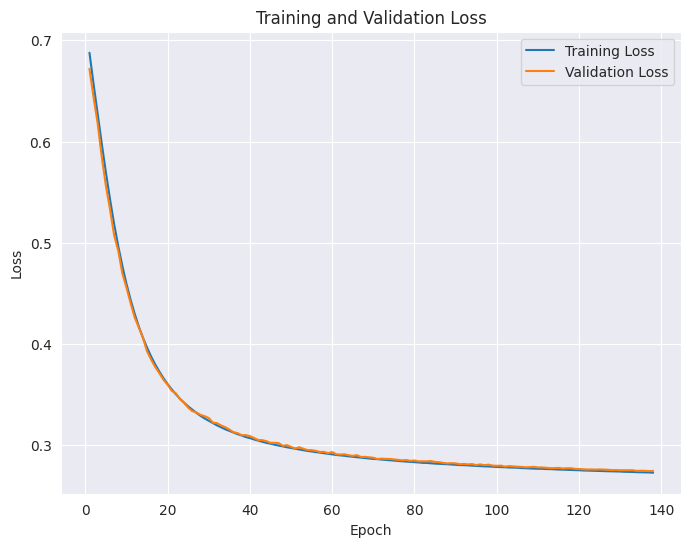

In [83]:
# Get number of epochs trained from saved model
checkpoint = torch.load("checkpoint.pt")
epochs = checkpoint["epoch"]

# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 2), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 2), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputLogits = model(images)
        outputs = torch.sigmoid(outputLogits) # Apply sigmoid to convert logits to get probabilities 0-1
        print(outputs)

tensor([[0.3757, 0.0735, 0.2962, 0.1460, 0.0500, 0.1359, 0.4829, 0.1024, 0.1041,
         0.0981, 0.0618, 0.0315, 0.0281, 0.0456],
        [0.3163, 0.0479, 0.2216, 0.1494, 0.0373, 0.0710, 0.5780, 0.0836, 0.0720,
         0.0642, 0.0408, 0.0220, 0.0165, 0.0293],
        [0.3939, 0.0254, 0.3640, 0.1155, 0.0282, 0.0507, 0.5639, 0.0558, 0.0389,
         0.0561, 0.0281, 0.0152, 0.0112, 0.0183],
        [0.3868, 0.0170, 0.2498, 0.0635, 0.0246, 0.0365, 0.6197, 0.0348, 0.0373,
         0.0357, 0.0177, 0.0065, 0.0075, 0.0098],
        [0.4027, 0.0929, 0.3478, 0.2329, 0.0712, 0.1018, 0.5232, 0.1019, 0.0967,
         0.1238, 0.0746, 0.0275, 0.0425, 0.0507],
        [0.4078, 0.0713, 0.3615, 0.1365, 0.0747, 0.1154, 0.6119, 0.1254, 0.0759,
         0.1028, 0.0551, 0.0295, 0.0434, 0.0436],
        [0.3598, 0.0123, 0.2255, 0.0565, 0.0123, 0.0253, 0.6775, 0.0294, 0.0274,
         0.0245, 0.0130, 0.0078, 0.0047, 0.0053],
        [0.3269, 0.0753, 0.2857, 0.2003, 0.0651, 0.1050, 0.6112, 0.0910, 0.0883,
  

In [85]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [86]:
def plot_confusion_matrices(matrices):
    ALLERGENS = [
        "Cereals containing gluten", "Crustaceans", "Eggs", "Fish",
        "Peanuts", "Soybeans", "Milk", "Nuts", "Celery", "Mustard",
        "Sesame seeds",  "Sulphur dioxide and sulphites", "Lupin", "Molluscs"
    ]

    # Plot matrices on seaborn
    for i, matrix in enumerate(matrices):
        plt.figure(figsize=(4, 3))
        sns.heatmap(
            matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"]
        )
        plt.title(f"Confusion Matrix: {ALLERGENS[i]}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.show()

In [87]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def test_loop(dataloader, model):
    model.eval()
    total, correct = 0, 0
    all_predictions = []
    all_actual = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputLogits = model(images)
            probs = torch.sigmoid(outputLogits) # Convert logits to probabilities
            preds = (probs > prediction_threshold).long() # Get binary predictions based on prediction threshold param

            total += labels.numel()
            correct += (preds == labels).sum().item()

            all_predictions.append(preds.cpu().numpy())
            all_actual.append(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Error: \n Accuracy: {accuracy:.2f} % \n\n')

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actual = np.concatenate(all_actual, axis=0)

    matrices = multilabel_confusion_matrix(all_actual, all_predictions)
    plot_confusion_matrices(matrices)

Test Error: 
 Accuracy: 88.74 % 




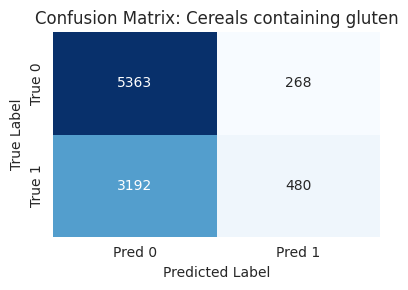

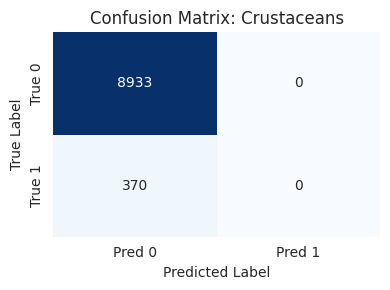

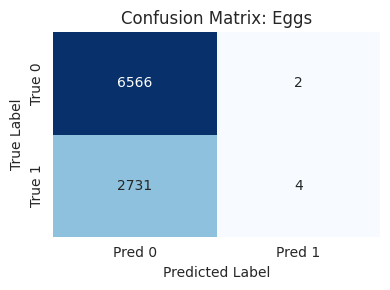

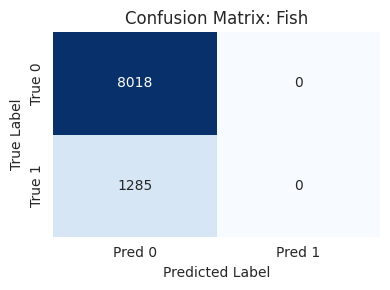

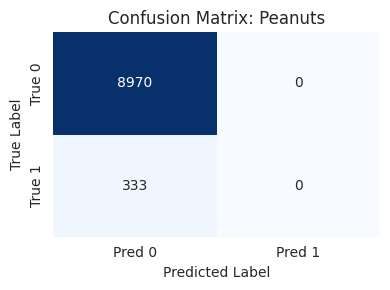

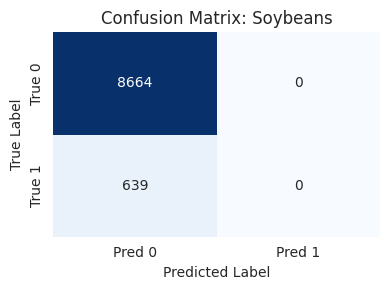

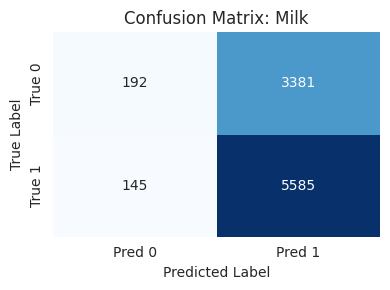

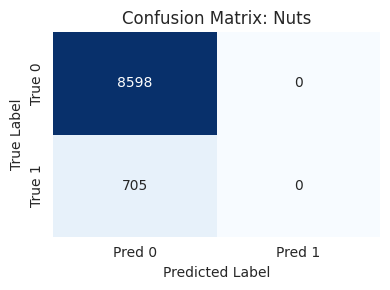

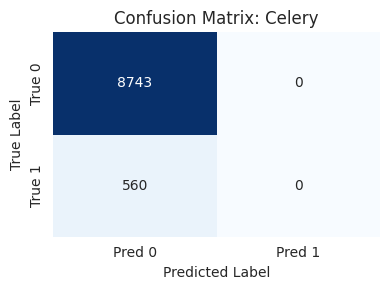

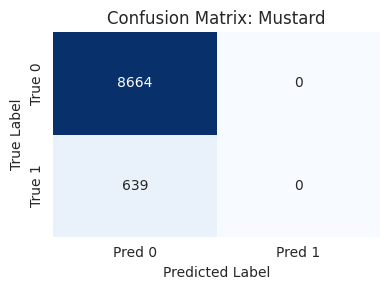

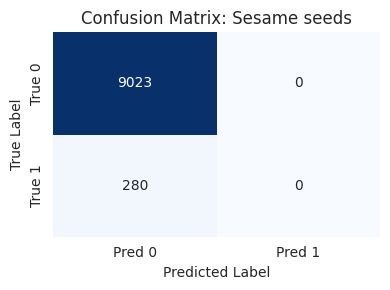

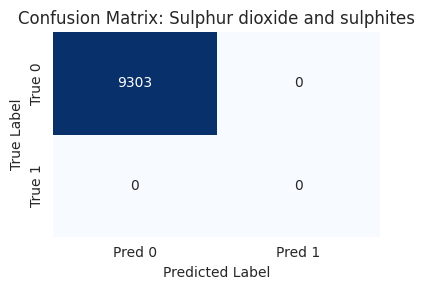

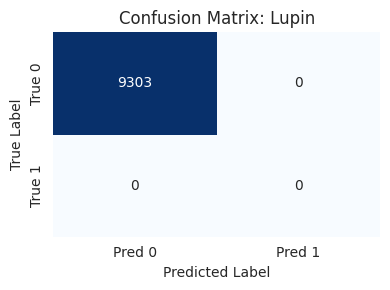

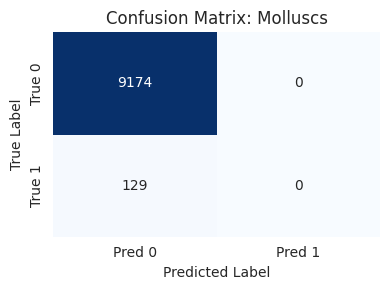

In [88]:
test_loop(test_dataloader, model)